In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import torch
from tqdm import tqdm
from transformers import pipeline

print(torch.cuda.is_available())

True


# Stock price preprocessing

yfinance preprocessing

In [2]:
import yfinance as yf
import pandas as pd

# Download stock data
df = yf.download("RELIANCE.NS", start="2003-04-01", end="2025-03-30", interval='1d')

# Reset index to make Date a column
df = df.reset_index()

# Step 1: Reset index to make 'Date' a column
df = df.reset_index()

# Step 2: Flatten the MultiIndex columns
df.columns = ['_'.join(col).strip() if isinstance(col, tuple) and col[1] else col[0] for col in df.columns]

# Step 3: Rename relevant columns
df = df.rename(columns={
    'Date': 'Date',
    'Close_RELIANCE.NS': 'Close',
    'High_RELIANCE.NS': 'High',
    'Low_RELIANCE.NS': 'Low',
    'Open_RELIANCE.NS': 'Open',
    'Volume_RELIANCE.NS': 'Volume'
})

# Step 4: Select required columns
df = df[['Date', 'Close', 'High', 'Low', 'Open', 'Volume']]

reliance = df
reliance.to_csv("reliance_1d.csv", index=False)

reliance.head()

[*********************100%***********************]  1 of 1 completed


,Date,Close,High,Low,Open,Volume
0,2003-04-01,16.066996,16.164180,15.778298,15.778298,37292645
1,2003-04-02,16.138453,16.349971,16.064134,16.152744,35008078
2,2003-04-03,16.321396,16.407147,16.124167,16.178477,31214340
3,2003-04-04,16.775873,16.813032,16.358548,16.358548,68828778
4,2003-04-07,17.158899,17.264659,16.864486,16.878777,69034657


Postional encoding + Attention embedding

In [3]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from torch import nn
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Learnable positional encoding for day positions
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        # learnable position embeddings: one vector per position in window
        self.pos_embedding = nn.Parameter(torch.randn(max_len, d_model))

    def forward(self, x):
        # x: [batch_size, seq_len, embed_dim]
        # add position embedding to each position
        return x + self.pos_embedding.unsqueeze(0)  # broadcast over batch

# Enhanced attention-based sentiment model
class EnhancedAttentionSentimentModel(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim // 2),
            nn.Tanh(),            # smoother gradients than ReLU
            nn.Dropout(0.1),      # regularization
            nn.Linear(embed_dim // 2, 1)
        )

    def forward(self, x, mask):
        # x: [batch_size, seq_len, embed_dim]
        # mask: [batch_size, seq_len]
        weights = self.attn(x).squeeze(-1)               # [batch, seq_len]
        weights = weights.masked_fill(mask == 0, -1e9)   # mask padding
        attn_scores = torch.softmax(weights, dim=-1)     # [batch, seq_len]
        # weighted sum over seq_len
        return torch.sum(x * attn_scores.unsqueeze(-1), dim=1)  # [batch, embed_dim]

# ------------------------ Load & preprocess data ------------------------

# Load news headlines
final_stock_news = pd.read_csv(r"C:\1 All about placements\Projects\Automated-Trading-Strategy-Optimization-Using-Multi-Modal-Reinforcement-Learning-1\Stocks_news\Final_stock_news.csv")
final_stock_news['Date'] = pd.to_datetime(
    final_stock_news['Date'], dayfirst=True
)

# Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained("mukaj/fin-mpnet-base")
model = AutoModel.from_pretrained("mukaj/fin-mpnet-base").to(device)
model.eval()

# Combine headline columns
headline_cols = [c for c in final_stock_news.columns if c.startswith("Headline_")]
final_stock_news["headline"] = (
    final_stock_news[headline_cols].fillna("").agg(" ".join, axis=1)
)

# Generate embeddings with proper attention pooling
def improved_mean_pooling(token_embeddings, attention_mask):
    """Attention‐weighted mean pooling that ignores padding."""
    mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_emb = torch.sum(token_embeddings * mask_expanded, dim=1)
    sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
    return sum_emb / sum_mask

BATCH_SIZE = 2
embeddings = []
for i in tqdm(range(0, len(final_stock_news), BATCH_SIZE), desc="Embedding"):
    batch_texts = final_stock_news["headline"].iloc[i:i+BATCH_SIZE].tolist()
    inputs = tokenizer(
        batch_texts,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    ).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        pooled = improved_mean_pooling(outputs.last_hidden_state, inputs['attention_mask'])
        embeddings.extend(pooled.cpu().numpy())

# Build DataFrame of embeddings+dates
final_stock_news["embedding"] = embeddings
embed_matrix = np.vstack(final_stock_news["embedding"].values)
embedding_df = pd.DataFrame(embed_matrix)
embedding_df["Date"] = final_stock_news["Date"].values

# Load trading dates
reliance = pd.read_csv(r'C:\1 All about placements\Projects\Automated-Trading-Strategy-Optimization-Using-Multi-Modal-Reinforcement-Learning-1\Stocks_news\reliance_1d.csv')
reliance["Date"] = pd.to_datetime(reliance["Date"], dayfirst=True, errors="coerce")
reliance = reliance.dropna(subset=["Date"]).sort_values("Date").reset_index(drop=True)

# ------------------------ Construct sentiment windows ------------------------

T = 3  # lookback window size (days)
window_embeddings, window_dates = [], []
last_valid_embedding = None
forward_fill_count = 0

for i, curr_date in enumerate(tqdm(reliance["Date"], desc="Windows")):
    if i >= T:
        start = reliance.iloc[i - T]["Date"]
        end   = reliance.iloc[i - 1]["Date"]
        window = embedding_df[
            (embedding_df["Date"] >= start) &
            (embedding_df["Date"] <= end)
        ].sort_values("Date")
        if len(window) > 0:
            emb_stack = window.drop(columns="Date").values
            tensor = torch.tensor(emb_stack, dtype=torch.float32)
            window_embeddings.append(tensor)
            window_dates.append(curr_date)
            last_valid_embedding = tensor
        else:
            forward_fill_count += 1
            if last_valid_embedding is not None:
                window_embeddings.append(last_valid_embedding.clone())
            else:
                neutral = torch.zeros((1, embed_matrix.shape[1]))
                window_embeddings.append(neutral)
                last_valid_embedding = neutral
            window_dates.append(curr_date)

print(f"Forward‐filled for {forward_fill_count}/{len(window_dates)} windows")

# ------------------------ Padding, Positional Encoding, & Attention ------------------------

if window_embeddings:
    max_len = max(w.shape[0] for w in window_embeddings)
    embed_dim = embed_matrix.shape[1]
    padded_inputs, masks = [], []

    for w in window_embeddings:
        seq_len = w.shape[0]
        pad_len = max_len - seq_len
        if pad_len > 0:
            pad = torch.zeros((pad_len, embed_dim))
            padded = torch.cat([pad, w], dim=0)
            mask   = torch.cat([torch.zeros(pad_len), torch.ones(seq_len)])
        else:
            padded = w
            mask   = torch.ones(max_len)
        padded_inputs.append(padded)
        masks.append(mask)

    inputs_tensor = torch.stack(padded_inputs).to(device)    # [B, L, D]
    masks_tensor  = torch.stack(masks).to(device)            # [B, L]

    # ---- Insert positional encoding ----
    pos_enc = PositionalEncoding(max_len, embed_dim).to(device)
    inputs_tensor = pos_enc(inputs_tensor)
    # ------------------------------------

    # Run enhanced attention model
    attention_model = EnhancedAttentionSentimentModel(embed_dim).to(device)
    with torch.no_grad():
        sentiment_index = attention_model(inputs_tensor, masks_tensor).cpu().numpy()

    # Save results
    sentiment_df = pd.DataFrame(sentiment_index)
    sentiment_df["Date"] = window_dates
    sentiment_df.to_csv("trading_date_sentiment_index_1d.csv", index=False)

    print(f"Sentiment index saved; shape = {sentiment_index.shape}")
    print(f"Average news articles per window: {np.mean([w.shape[0] for w in window_embeddings]):.2f}")
    print(f"Max news articles in a window: {max([w.shape[0] for w in window_embeddings])}")
    print(f"Min news articles in a window: {min([w.shape[0] for w in window_embeddings])}")
else:
    print("No sentiment windows created—check data alignment.")


Using device: cuda


Windows: 100%|██████████| 5452/5452 [00:08<00:00, 638.01it/s]


Forward‐filled for 86/5449 windows
Sentiment index saved; shape = (5449, 768)
Average news articles per window: 3.73
Max news articles in a window: 8
Min news articles in a window: 1


In [22]:
import pandas as pd
trading_date_sentiment_index = pd.read_csv(
    r'C:\1 All about placements\Projects\Automated-Trading-Strategy-Optimization-Using-Multi-Modal-Reinforcement-Learning-1\Stocks_news\trading_date_sentiment_index_1d.csv'
)

# Identify purely numeric columns (these are likely your embeddings)
numeric_cols = [col for col in trading_date_sentiment_index.columns if col.replace('.', '', 1).isdigit()]

# Rename them to emb_0, emb_1, ...
new_names = {col: f"emb_{i}" for i, col in enumerate(numeric_cols)}
trading_date_sentiment_index.rename(columns=new_names, inplace=True)

# Optional: Save back with renamed columns
trading_date_sentiment_index.to_csv(
    r'C:\1 All about placements\Projects\Automated-Trading-Strategy-Optimization-Using-Multi-Modal-Reinforcement-Learning-1\Stocks_news\trading_date_sentiment_index_1d.csv',
    index=False
)
trading_date_sentiment_index.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767,Date
0,1.007953,-0.043733,-0.499889,0.147613,-0.964991,0.375755,0.080850,-0.566306,-0.258606,0.008842,...,-0.127674,-0.352718,-1.229073,-0.660850,-0.011092,0.126984,-0.070164,-1.140411,0.572524,2003-04-04
1,0.997226,-0.066451,-0.475999,0.181677,-0.937462,0.380942,0.138040,-0.552204,-0.224864,0.050794,...,-0.135448,-0.283369,-1.240613,-0.682083,0.018468,0.101288,-0.103782,-1.090174,0.549657,2003-04-07
2,0.965857,-0.446194,-0.019417,-0.099439,-0.650021,0.737560,-0.292675,-0.816064,0.034981,0.344674,...,0.028931,0.132436,-0.986054,-0.310185,0.051073,0.071426,-0.169723,-0.396854,0.531457,2003-04-08
3,1.009024,-0.313397,-0.045782,-0.103766,-0.576613,0.718984,-0.274195,-0.830338,0.013181,0.284923,...,0.021328,0.052169,-1.067832,-0.317469,-0.051493,0.109893,-0.326055,-0.516760,0.676003,2003-04-09
4,1.059863,0.184162,-0.494945,0.112402,-0.925250,0.492989,-0.008212,-0.556213,-0.239447,-0.060997,...,-0.159464,-0.318933,-1.296591,-0.635474,-0.167605,0.135469,-0.199011,-1.138675,0.696578,2003-04-10


Embeddings shape: (5449, 768)
Computing clustering metrics...


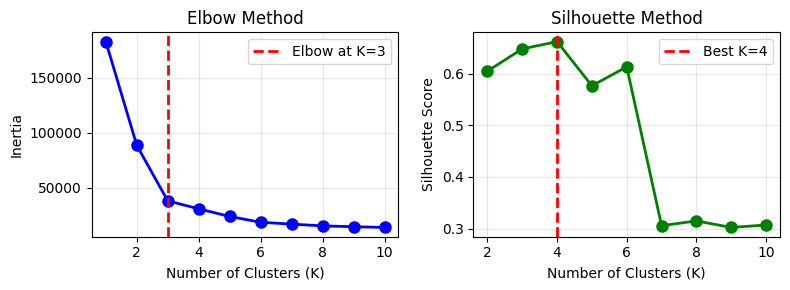

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

# Load your embeddings
sentiment_df = pd.read_csv(r'C:\1 All about placements\Projects\Automated-Trading-Strategy-Optimization-Using-Multi-Modal-Reinforcement-Learning-1\Stocks_news\trading_date_sentiment_index_1d.csv')
embeddings = sentiment_df.iloc[:, :-1].values  # All columns except Date

print(f"Embeddings shape: {embeddings.shape}")

# Range of clusters to test
K_range = range(1, 11)  # 1 to 10 clusters

# Calculate both metrics
inertias = []  # For Elbow Method
silhouette_scores = []  # For Silhouette Method

print("Computing clustering metrics...")

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    inertias.append(kmeans.inertia_)
    
    if k > 1:
        sil_score = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(sil_score)

# Find elbow point automatically
kl = KneeLocator(K_range, inertias, curve="convex", direction="decreasing")
elbow_point = kl.elbow

# Find best silhouette score
best_silhouette_k = K_range[1:][np.argmax(silhouette_scores)]  # silhouette starts from k=2
best_silhouette_score = max(silhouette_scores)

# Plot only first two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# 1. Elbow Method Plot
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
if elbow_point:
    ax1.axvline(x=elbow_point, color='red', linestyle='--', linewidth=2, 
                label=f'Elbow at K={elbow_point}')
    ax1.legend()
ax1.set_xlabel('Number of Clusters (K)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)

# 2. Silhouette Method Plot
ax2.plot(K_range[1:], silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.axvline(x=best_silhouette_k, color='red', linestyle='--', linewidth=2,
            label=f'Best K={best_silhouette_k}')
ax2.legend()
ax2.set_xlabel('Number of Clusters (K)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Method')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [46]:
from sklearn.cluster import KMeans

k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)

sentiment_df["Cluster"] = cluster_labels
print(sentiment_df["Cluster"].value_counts().sort_index())

0    2261
1    3099
2      89
Name: Cluster, dtype: int64


In [47]:
from transformers import AutoTokenizer, AutoModel
model_name = "mukaj/fin-mpnet-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

sentiment_queries = {
    0: "sad news for stock market",
    1: "Nuetral news for stock market slightup/down",
    2: "Good news for stock market"
}


sentiment_labels = {
    0: "Bearish",
    1: "Nuetral",
    2: "Bullish"
}

In [48]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

# === Step 0: Ensure embedding columns are named correctly ===
embedding_columns = [col for col in trading_date_sentiment_index.columns if col.startswith("emb_")]

# Check embedding column validity
if not embedding_columns:
    raise ValueError("No embedding columns found. Make sure they are named as 'emb_0', 'emb_1', ..., etc.")

# === Step 1: Compute centroids of each cluster ===
cluster_centroids = sentiment_df.groupby("Cluster")[embedding_columns].mean()

# === Step 2: Define function to encode sentiment queries ===
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        output = model(**inputs)
    return output.last_hidden_state.mean(dim=1).squeeze().numpy()

# === Step 3: Create embeddings for the sentiment queries ===
sentiment_embeddings = {
    label: get_embedding(text) for label, text in sentiment_queries.items()
}

from scipy.optimize import linear_sum_assignment

# Step 4 (revised): Build similarity matrix (clusters x sentiments)
sim_matrix = []
for _, centroid in cluster_centroids.iterrows():
    centroid_vector = centroid.values.reshape(1, -1)
    sims = [
        cosine_similarity(
            centroid_vector,
            sentiment_embeddings[label].reshape(1, -1)
        )[0][0]
        for label in sentiment_queries
    ]
    sim_matrix.append(sims)

sim_matrix = np.array(sim_matrix)  # shape: (num_clusters, num_sentiments)

# Convert to cost matrix (Hungarian solves min-cost, so negate similarities)
cost_matrix = -sim_matrix
row_ind, col_ind = linear_sum_assignment(cost_matrix)

# Build unique mapping: cluster index → sentiment label
cluster_ids = cluster_centroids.index.tolist()
cluster_to_sentiment = {cluster_ids[i]: col_ind[i] for i in range(len(cluster_ids))}


# === Step 5: Assign sentiment labels and descriptions to each row in sentiment_df ===
sentiment_df["Sentiment_Label"] = sentiment_df["Cluster"].map(cluster_to_sentiment)
sentiment_df["Sentiment_Text"] = sentiment_df["Sentiment_Label"].map(sentiment_queries)
sentiment_df["Sentiment_Description"] = sentiment_df["Sentiment_Label"].map(sentiment_labels)

final_sentiment = sentiment_df.copy()
final_sentiment.to_csv("final_sentiment_1d.csv", index=False)

final_sentiment["Sentiment_Description"].value_counts()

Bullish    3099
Bearish    2261
Nuetral      89
Name: Sentiment_Description, dtype: int64

In [49]:
final_sentiment.head(2)

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_763,emb_764,emb_765,emb_766,emb_767,Date,Cluster,Sentiment_Label,Sentiment_Text,Sentiment_Description
0,1.007953,-0.043733,-0.499889,0.147613,-0.964991,0.375755,0.08085,-0.566306,-0.258606,0.008842,...,-0.011092,0.126984,-0.070164,-1.140411,0.572524,2003-04-04,1,2,Good news for stock market,Bullish
1,0.997226,-0.066451,-0.475999,0.181677,-0.937462,0.380942,0.13804,-0.552204,-0.224864,0.050794,...,0.018468,0.101288,-0.103782,-1.090174,0.549657,2003-04-07,1,2,Good news for stock market,Bullish


In [56]:
import pandas as pd

# Load and prepare data
# df = pd.read_csv(r'C:\1 All about placements\Projects\Automated-Trading-Strategy-Optimization-Using-Multi-Modal-Reinforcement-Learning-1\Stocks_news\trading_date_sentiment_index.csv')
final_sentiment['Date'] = pd.to_datetime(final_sentiment['Date'])

# Filter Feb–Apr 2020
phase_1 = final_sentiment[(final_sentiment['Date'] >= "2020-02-01") & (final_sentiment['Date'] <= "2020-04-1")]
print("Sentiment Counts (Feb–Apr 2020):")
print(phase_1['Sentiment_Description'].value_counts().sort_index(), '\n')

# Filter Nov–Dec 2020
phase_2 = final_sentiment[(final_sentiment['Date'] >= "2020-11-01") & (final_sentiment['Date'] <= "2020-12-31")]
print("Sentiment Counts (Nov–Dec 2020):")
print(phase_2['Sentiment_Description'].value_counts().sort_index())

Sentiment Counts (Feb–Apr 2020):
Bearish    19
Bullish    22
Name: Sentiment_Description, dtype: int64 

Sentiment Counts (Nov–Dec 2020):
Bearish     1
Bullish    41
Name: Sentiment_Description, dtype: int64


In [65]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

# Load both datasets
sentiment_df = pd.read_csv(r"C:\1 All about placements\Projects\Automated-Trading-Strategy-Optimization-Using-Multi-Modal-Reinforcement-Learning-1\Stocks_news\final_sentiment_1d.csv", usecols=["Date", "Sentiment_Label"])
sentiment_df["Date"] = pd.to_datetime(sentiment_df["Date"])

reliance_df = pd.read_csv(r'C:\1 All about placements\Projects\Automated-Trading-Strategy-Optimization-Using-Multi-Modal-Reinforcement-Learning-1\Stocks_news\reliance_1d.csv')
reliance_df["Date"] = pd.to_datetime(reliance_df["Date"])

# Merge on 'Date'
merged_df = pd.merge(reliance_df, sentiment_df, on="Date", how="inner")

final_sentiment = merged_df.copy()
final_sentiment.to_csv("reliance_stocknsentiment_1d.csv", index=False)

reliance_stocknsentiment= pd.read_csv(r"C:\1 All about placements\Projects\Automated-Trading-Strategy-Optimization-Using-Multi-Modal-Reinforcement-Learning-1\Stocks_news\reliance_stocknsentiment_1d.csv")

reliance_stocknsentiment.head()

,Date,Close,High,Low,Open,Volume,Sentiment_Label
0,2003-04-04,16.775873,16.813032,16.358548,16.358548,68828778,2
1,2003-04-07,17.158899,17.264659,16.864486,16.878777,69034657,2
2,2003-04-08,16.930229,17.081724,16.835902,17.035989,42376062,0
3,2003-04-09,16.484318,16.858765,16.435725,16.758722,44544841,0
4,2003-04-10,16.307100,16.492895,16.127021,16.458595,40775373,2


# Daily TFT prediction

In [ ]:
# Handeled indexing issue

import pandas as pd
import numpy as np

def create_time_index_options(df):
    """
    Different ways to create time_idx for stock data to avoid gaps
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date').reset_index(drop=True)
    
    print("Time Index Options for Stock Data:")
    print("=" * 50)
    
    # Option 1: Sequential trading days (RECOMMENDED)
    df['time_idx_sequential'] = range(len(df))
    print(f"1. Sequential Trading Days: {df['time_idx_sequential'].min()} to {df['time_idx_sequential'].max()}")
    print(f"   No gaps, perfect for TFT")
    print(f"   Sample: {df['time_idx_sequential'].head(10).tolist()}")
    
    # Option 2: Business days from start
    business_days = pd.bdate_range(start=df['Date'].min(), end=df['Date'].max())
    date_to_bday = {date: idx for idx, date in enumerate(business_days)}
    df['time_idx_business'] = df['Date'].map(date_to_bday)
    print(f"\n2. Business Days Index: {df['time_idx_business'].min()} to {df['time_idx_business'].max()}")
    print(f"   May have small gaps for holidays")
    print(f"   Sample: {df['time_idx_business'].head(10).tolist()}")
    
    # Option 3: Weekly grouping (your original approach)
    df['time_idx_weekly'] = (df['Date'] - df['Date'].min()).dt.days // 7
    print(f"\n3. Weekly Grouping: {df['time_idx_weekly'].min()} to {df['time_idx_weekly'].max()}")
    print(f"   Good for longer-term patterns")
    print(f"   Sample: {df['time_idx_weekly'].head(10).tolist()}")
    
    # Option 4: Calendar days with allow_missing_timesteps=True
    df['time_idx_calendar'] = (df['Date'] - df['Date'].min()).dt.days
    print(f"\n4. Calendar Days: {df['time_idx_calendar'].min()} to {df['time_idx_calendar'].max()}")
    print(f"   Requires allow_missing_timesteps=True")
    print(f"   Sample: {df['time_idx_calendar'].head(10).tolist()}")
    
    return df

# For your specific use case, here's the recommended approach:
def prepare_stock_data_for_tft(csv_file):
    """
    Prepare stock data with optimal time indexing for TFT
    """
    print("Preparing Stock Data for TFT...")
    
    # Load data
    df = pd.read_csv(csv_file, parse_dates=["Date"])
    df = df.sort_values("Date").reset_index(drop=True)
    
    # Method 1: Sequential trading days (BEST for most cases)
    df["time_idx"] = range(len(df))
    df["series_id"] = "stock"
    
    # Add day-of-week info to preserve calendar patterns
    df["day_of_week"] = df["Date"].dt.dayofweek
    df["month"] = df["Date"].dt.month
    df["quarter"] = df["Date"].dt.quarter
    
    # Check for any remaining gaps (shouldn't be any with sequential)
    time_diff = df["time_idx"].diff().dropna()
    max_gap = time_diff.max()
    
    print(f"Time index created: {df['time_idx'].min()} to {df['time_idx'].max()}")
    print(f"Maximum gap between consecutive days: {max_gap}")
    print(f"Total trading days: {len(df)}")
    
    if max_gap > 1:
        print("Warning: Gaps detected! Consider using allow_missing_timesteps=True")
    else:
        print("No gaps detected - perfect for TFT!")
    
    return df

# Usage example:
# df = prepare_stock_data_for_tft("reliance_stocknsentiment_1d.csv")

# TimeSeriesDataSet configuration for stock data:
def create_tft_dataset_for_stocks(df, target_col="Close"):
    """
    Create TFT dataset optimized for stock data
    """
    from pytorch_forecasting import TimeSeriesDataSet, GroupNormalizer
    
    # Ensure proper data types
    df["series_id"] = df["series_id"].astype(str)
    if "Sentiment_Label" in df.columns:
        df["Sentiment_Label"] = df["Sentiment_Label"].astype(str)
    
    # Parameters optimized for daily stock prediction
    max_prediction_length = 5    # Predict 1 week ahead
    max_encoder_length = 30      # Use 6 weeks of history
    
    # Split data
    training_cutoff = df["time_idx"].max() - max_prediction_length - 10
    
    training_data = df[df["time_idx"] <= training_cutoff]
    
    # Create dataset
    training_dataset = TimeSeriesDataSet(
        training_data,
        time_idx="time_idx",
        target=target_col,
        group_ids=["series_id"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        
        # Static features (don't change over time)
        static_categoricals=["series_id"],
        
        # Known categorical features (available for future)
        time_varying_known_categoricals=[
            "day_of_week", "month", "quarter"
        ] + (["Sentiment_Label"] if "Sentiment_Label" in df.columns else []),
        
        # Known continuous features (available for future)
        time_varying_known_reals=["time_idx"],
        
        # Unknown features (only historical values available)
        time_varying_unknown_reals=[
            col for col in df.columns 
            if col not in ["Date", "time_idx", "series_id", "day_of_week", 
                          "month", "quarter", "Sentiment_Label", target_col]
            and df[col].dtype in ['float64', 'float32', 'int64', 'int32']
        ],
        
        # Normalization
        target_normalizer=GroupNormalizer(groups=["series_id"]),
        
        # Additional features
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        
        # No missing timesteps needed with sequential index
        allow_missing_timesteps=False,
    )
    
    print(f"TFT Dataset created successfully!")
    print(f"   Training samples: {len(training_data)}")
    print(f"   Encoder length: {max_encoder_length} days")
    print(f"   Prediction length: {max_prediction_length} days")
    print(f"   Features: {len(training_dataset.reals + training_dataset.categoricals)} total")
    
    return training_dataset

# Debug function to check your data
def debug_time_index(df):
    """
    Debug function to check time index issues
    """
    print("Time Index Debugging:")
    print("=" * 30)
    
    df_sorted = df.sort_values("time_idx")
    
    # Check for gaps
    time_diff = df_sorted["time_idx"].diff().dropna()
    gaps = time_diff[time_diff > 1]
    
    print(f"Time index range: {df_sorted['time_idx'].min()} to {df_sorted['time_idx'].max()}")
    print(f"Total records: {len(df_sorted)}")
    print(f"Expected sequential length: {df_sorted['time_idx'].max() - df_sorted['time_idx'].min() + 1}")
    
    if len(gaps) > 0:
        print(f"Found {len(gaps)} gaps in time index:")
        gap_locations = df_sorted[df_sorted["time_idx"].diff() > 1]["time_idx"].head(5)
        print(f"   Gap locations: {gap_locations.tolist()}")
        print(f"   Largest gap: {gaps.max()}")
        print("\n   Solutions:")
        print("   1. Use allow_missing_timesteps=True")
        print("   2. Create sequential index: df['time_idx'] = range(len(df))")
        print("   3. Fill missing dates with interpolation")
    else:
        print("No gaps found - perfect for TFT!")
    
    return gaps

In [ ]:
# Model training - 200 min.
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

# Fix NumPy compatibility
np.float = float
np.int = int
np.complex = complex
np.bool = bool

import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

torch.set_float32_matmul_precision('medium')

def calculate_technical_indicators(df):
    """Add technical indicators for better stock prediction"""
    df = df.copy()
    
    # Moving averages
    df['SMA_5'] = df['Close'].rolling(5).mean()
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['EMA_12'] = df['Close'].ewm(span=12).mean()
    
    # Price changes and volatility
    df['Price_Change'] = df['Close'].pct_change()
    df['Volatility'] = df['Close'].rolling(10).std()
    
    # Relative Strength Index (simplified)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp1 = df['Close'].ewm(span=12).mean()
    exp2 = df['Close'].ewm(span=26).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
    
    # Bollinger Bands
    bb_period = 20
    bb_std = 2
    df['BB_Middle'] = df['Close'].rolling(bb_period).mean()
    bb_std_val = df['Close'].rolling(bb_period).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std_val * bb_std)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std_val * bb_std)
    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    # Volume indicators
    df['Volume_MA'] = df['Volume'].rolling(10).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']
    
    # Day of week and month effects
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Month'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter
    
    return df

def hyperparameter_tune_tft():
    print("Starting Enhanced TFT Hyperparameter Optimization for Daily Stock Data")
    print("=" * 70)
    
    # Load and prepare data
    df = pd.read_csv(r"C:\1 All about placements\Projects\Automated-Trading-Strategy-Optimization-Using-Multi-Modal-Reinforcement-Learning-1\Stocks_news\reliance_stocknsentiment_1d.csv", parse_dates=["Date"])
    df = df.sort_values("Date").reset_index(drop=True)
    
    # Add technical indicators
    print("Adding technical indicators...")
    df = calculate_technical_indicators(df)
    
    # Create trading day index (consecutive integers) instead of calendar days
    # This avoids gaps from weekends/holidays
    df = df.sort_values("Date").reset_index(drop=True)
    df["time_idx"] = range(len(df))  # Sequential trading days: 0, 1, 2, 3...
    df["series_id"] = "reliance"
    
    print(f"Time index range: {df['time_idx'].min()} to {df['time_idx'].max()}")
    
    print(f"Dataset: {df.shape[0]} rows, {df.shape[1]} features")
    
    # Parameters optimized for daily stock prediction
    max_prediction_length = 5  # Predict 5 days ahead (1 trading week)
    max_encoder_length = 30   # Use 30 days of history (1.5 months)
    training_cutoff = df["time_idx"].max() - max_prediction_length - 15
    validation_cutoff = df["time_idx"].max() - max_prediction_length
    
    # Split data
    train_data = df[df["time_idx"] <= training_cutoff].copy()
    val_data = df[(df["time_idx"] > training_cutoff) & (df["time_idx"] <= validation_cutoff)].copy()
    test_data = df[df["time_idx"] > validation_cutoff].copy()
    
    print(f"Data split: {len(train_data)} train, {len(val_data)} val, {len(test_data)} test")
    
    # Scale continuous features
    scaler = StandardScaler()
    continuous_cols = [
        "Open", "High", "Low", "Close", "Volume",
        "SMA_5", "SMA_20", "EMA_12", "Price_Change", "Volatility",
        "RSI", "MACD", "MACD_Signal", "BB_Middle", "BB_Upper", "BB_Lower", 
        "BB_Position", "Volume_MA", "Volume_Ratio"
    ]
    
    # Remove NaN values and scale
    for data in [train_data, val_data, test_data]:
        data.dropna(inplace=True)
    
    if len(train_data) > 0:
        train_data[continuous_cols] = scaler.fit_transform(train_data[continuous_cols])
        val_data[continuous_cols] = scaler.transform(val_data[continuous_cols])
        test_data[continuous_cols] = scaler.transform(test_data[continuous_cols])
    
    # Combine for dataset creation
    df_scaled = pd.concat([train_data, val_data, test_data]).sort_values("time_idx").reset_index(drop=True)
    df_scaled["Sentiment_Label"] = df_scaled["Sentiment_Label"].astype(str)
    
    # Prepare categorical features
    categorical_cols = ["DayOfWeek", "Month", "Quarter"]
    for col in categorical_cols:
        df_scaled[col] = df_scaled[col].astype(str)
    
    # Create training dataset with enhanced features
    training_dataset = TimeSeriesDataSet(
        df_scaled[df_scaled["time_idx"] <= training_cutoff],
        time_idx="time_idx",
        target="Close",
        group_ids=["series_id"],
        max_encoder_length=max_encoder_length,
        max_prediction_length=max_prediction_length,
        static_categoricals=["series_id"],
        time_varying_known_categoricals=["Sentiment_Label", "DayOfWeek", "Month", "Quarter"],
        time_varying_known_reals=["time_idx"],
        time_varying_unknown_reals=[
            "Open", "High", "Low", "Volume", "SMA_5", "SMA_20", "EMA_12", 
            "Price_Change", "Volatility", "RSI", "MACD", "MACD_Signal",
            "BB_Position", "Volume_Ratio"
        ],
        target_normalizer=GroupNormalizer(groups=["series_id"]),
        add_relative_time_idx=True,
        add_target_scales=True,
        add_encoder_length=True,
        allow_missing_timesteps=False,  # Not needed with sequential trading days
    )
    
    # Create validation dataset
    validation_dataset = TimeSeriesDataSet.from_dataset(
        training_dataset, 
        df_scaled[df_scaled["time_idx"] <= validation_cutoff],
        predict=True, 
        stop_randomization=True
    )
    
    # Create dataloaders
    batch_size = 16  # Smaller batch size for more stable training
    train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
    
    print(f"Created dataloaders: {len(train_dataloader)} train, {len(val_dataloader)} val batches")
    
    # Enhanced parameter combinations for stock prediction
    param_combinations = [
        # Conservative approaches
        {"learning_rate": 0.001, "hidden_size": 32, "attention_head_size": 2, "dropout": 0.1},
        {"learning_rate": 0.003, "hidden_size": 64, "attention_head_size": 4, "dropout": 0.15},
        
        # Moderate complexity
        {"learning_rate": 0.005, "hidden_size": 96, "attention_head_size": 6, "dropout": 0.2},
        {"learning_rate": 0.01, "hidden_size": 128, "attention_head_size": 8, "dropout": 0.25},
        
        # Higher capacity
        {"learning_rate": 0.002, "hidden_size": 160, "attention_head_size": 10, "dropout": 0.3},
        {"learning_rate": 0.0005, "hidden_size": 192, "attention_head_size": 12, "dropout": 0.2},
        
        # Specialized for financial data
        {"learning_rate": 0.007, "hidden_size": 80, "attention_head_size": 5, "dropout": 0.18},
        {"learning_rate": 0.004, "hidden_size": 112, "attention_head_size": 7, "dropout": 0.22},
    ]
    
    print(f"\nRunning manual hyperparameter search with {len(param_combinations)} combinations...")
    print("-" * 70)
    
    best_loss = float('inf')
    best_params = None
    results = []
    
    for i, params in enumerate(param_combinations):
        print(f"\nTrial {i+1}/{len(param_combinations)}: {params}")
        
        try:
            # Create model with current parameters
            model = TemporalFusionTransformer.from_dataset(
                training_dataset,
                learning_rate=params["learning_rate"],
                hidden_size=params["hidden_size"],
                attention_head_size=params["attention_head_size"],
                dropout=params["dropout"],
                hidden_continuous_size=params["hidden_size"] // 2,
                loss=QuantileLoss(),
                reduce_on_plateau_patience=4,
                optimizer="AdamW",
                weight_decay=1e-4,  # Add regularization
            )
            
            # Training for evaluation
            trainer = Trainer(
                max_epochs=20,
                gradient_clip_val=0.1,
                enable_checkpointing=False,
                logger=False,
                enable_progress_bar=True,
                check_val_every_n_epoch=3,
                accelerator='gpu' if torch.cuda.is_available() else 'cpu',
                devices=1,
            )
            
            trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
            
            # Get validation loss
            val_loss = float(trainer.callback_metrics.get('val_loss', float('inf')))
            results.append((params, val_loss))
            
            print(f"   Validation loss: {val_loss:.4f}")
            
            if val_loss < best_loss:
                best_loss = val_loss
                best_params = params
                print(f"   *** New best parameters! ***")
            
        except Exception as e:
            print(f"   Trial failed: {str(e)[:50]}...")
            results.append((params, float('inf')))
    
    print(f"\nHyperparameter search completed!")
    print(f"Best validation loss: {best_loss:.4f}")
    print(f"Best parameters: {best_params}")
    
    # Train final model with best parameters
    print(f"\nTraining final model with optimized parameters...")
    print("-" * 70)
    
    final_model = TemporalFusionTransformer.from_dataset(
        training_dataset,
        learning_rate=best_params["learning_rate"],
        hidden_size=best_params["hidden_size"],
        attention_head_size=best_params["attention_head_size"],
        dropout=best_params["dropout"],
        hidden_continuous_size=best_params["hidden_size"] // 2,
        loss=QuantileLoss(),
        reduce_on_plateau_patience=5,
        optimizer="AdamW",
        weight_decay=1e-4,
    )
    
    # Final training with early stopping
    early_stopping = EarlyStopping(monitor="val_loss", patience=10, mode="min")
    
    final_trainer = Trainer(
        max_epochs=100,
        gradient_clip_val=0.1,
        callbacks=[early_stopping],
        enable_checkpointing=False,
        logger=False,
        enable_progress_bar=True,
        check_val_every_n_epoch=1,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
    )
    
    print("Training final model...")
    try:
        final_trainer.fit(final_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
        print(f"Final training completed after {final_trainer.current_epoch + 1} epochs!")
    except Exception as e:
        print(f"Final training completed: {str(e)[:50]}...")
    
    # Evaluate final model
    print(f"\nEvaluating final model on test data...")
    
    # Create test dataset
    test_dataset = TimeSeriesDataSet.from_dataset(training_dataset, df_scaled, predict=True, stop_randomization=True)
    test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
    
    # Make predictions
    predictions = final_model.predict(test_dataloader)
    actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
    
    predictions_np = predictions.cpu().numpy()
    actuals_np = actuals.cpu().numpy()
    
    # Transform back to original scale
    def inverse_transform_prices(scaled_values):
        dummy = np.zeros((len(scaled_values), len(continuous_cols)))
        dummy[:, 3] = scaled_values  # Close price is at index 3
        return scaler.inverse_transform(dummy)[:, 3]
    
    if len(predictions_np.shape) > 1:
        pred_prices = []
        actual_prices = []
        for i in range(predictions_np.shape[0]):
            pred_prices.extend(inverse_transform_prices(predictions_np[i]))
            actual_prices.extend(inverse_transform_prices(actuals_np[i]))
        pred_prices = np.array(pred_prices)
        actual_prices = np.array(actual_prices)
    else:
        pred_prices = inverse_transform_prices(predictions_np)
        actual_prices = inverse_transform_prices(actuals_np)
    
    # Calculate comprehensive metrics
    mae = mean_absolute_error(actual_prices, pred_prices)
    rmse = np.sqrt(mean_squared_error(actual_prices, pred_prices))
    mape = np.mean(np.abs((actual_prices - pred_prices) / actual_prices)) * 100
    
    # Directional accuracy (important for trading)
    actual_direction = np.sign(np.diff(actual_prices))
    pred_direction = np.sign(np.diff(pred_prices))
    directional_accuracy = np.mean(actual_direction == pred_direction) * 100
    
    print("\n" + "=" * 70)
    print("ENHANCED TFT HYPERPARAMETER TUNING RESULTS")
    print("=" * 70)
    print(f"Dataset: Daily stock data with {len(continuous_cols)} technical indicators")
    print(f"Prediction horizon: {max_prediction_length} days")
    print(f"Training samples: {len(train_data)}")
    
    print(f"\nBest Parameters Found:")
    for key, value in best_params.items():
        print(f"   {key}: {value}")
    
    print(f"\nFinal Model Performance:")
    print(f"   MAE:  ${mae:.2f}")
    print(f"   RMSE: ${rmse:.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   Directional Accuracy: {directional_accuracy:.1f}%")
    
    print(f"\nSample Predictions (Last 5):")
    for i in range(max(0, len(pred_prices)-5), len(pred_prices)):
        error_pct = abs(actual_prices[i] - pred_prices[i]) / actual_prices[i] * 100
        print(f"   Day {i+1}: Actual=${actual_prices[i]:.2f}, Predicted=${pred_prices[i]:.2f}, Error={error_pct:.1f}%")
    
    # Performance assessment for stock prediction
    if mape < 3:
        print(f"\nOutstanding! MAPE of {mape:.2f}% is excellent for daily stock prediction")
    elif mape < 7:
        print(f"\nVery Good! MAPE of {mape:.2f}% is quite good for daily stock prediction")
    elif mape < 15:
        print(f"\nGood! MAPE of {mape:.2f}% is acceptable for daily stock prediction")
    else:
        print(f"\nMAPE of {mape:.2f}% suggests room for improvement")
    
    if directional_accuracy > 60:
        print(f"Directional accuracy of {directional_accuracy:.1f}% is promising for trading signals")
    
    return {
        'best_params': best_params,
        'final_model': final_model,
        'predictions': pred_prices,
        'actuals': actual_prices,
        'metrics': {
            'mae': mae, 
            'rmse': rmse, 
            'mape': mape,
            'directional_accuracy': directional_accuracy
        },
        'scaler': scaler,
        'training_dataset': training_dataset
    }

# Run the enhanced hyperparameter tuning
if __name__ == "__main__":
    print("Starting enhanced hyperparameter tuning for daily stock prediction...")
    print("This includes technical indicators and optimized parameters for financial data!")
    results = hyperparameter_tune_tft()

Starting enhanced hyperparameter tuning for daily stock prediction...
This includes technical indicators and optimized parameters for financial data!
Starting Enhanced TFT Hyperparameter Optimization for Daily Stock Data
Adding technical indicators...
Time index range: 0 to 5448
Dataset: 5449 rows, 26 features
Data split: 5429 train, 15 val, 5 test


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Created dataloaders: 336 train, 1 val batches

Running manual hyperparameter search with 8 combinations...
----------------------------------------------------------------------

Trial 1/8: {'learning_rate': 0.001, 'hidden_size': 32, 'attention_head_size': 2, 'dropout': 0.1}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 129   
3  | prescalers                         | ModuleDict                      | 608   
4  | static_variable_selection          | VariableSelectionNetwork        | 5.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 37.0 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 4.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm 

Epoch 19: 100%|██████████| 336/336 [00:24<00:00, 13.61it/s, loss=0.0129, train_loss_step=0.0127, train_loss_epoch=0.0141, val_loss=0.0261] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 336/336 [00:24<00:00, 13.61it/s, loss=0.0129, train_loss_step=0.0127, train_loss_epoch=0.0141, val_loss=0.0261]
   Validation loss: 0.0261
   *** New best parameters! ***

Trial 2/8: {'learning_rate': 0.003, 'hidden_size': 64, 'attention_head_size': 4, 'dropout': 0.15}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 129   
3  | prescalers                         | ModuleDict                      | 1.2 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 20.8 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 121 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 15.2 K
7  | static_context_variable_selection  | GatedResid

Epoch 19: 100%|██████████| 336/336 [26:24<00:00,  4.72s/it, loss=0.0151, train_loss_step=0.0122, train_loss_epoch=0.0142, val_loss=0.0226]   

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 336/336 [26:24<00:00,  4.72s/it, loss=0.0151, train_loss_step=0.0122, train_loss_epoch=0.0142, val_loss=0.0226]
   Validation loss: 0.0226
   *** New best parameters! ***

Trial 3/8: {'learning_rate': 0.005, 'hidden_size': 96, 'attention_head_size': 6, 'dropout': 0.2}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 129   
3  | prescalers                         | ModuleDict                      | 1.8 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 45.0 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 255 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 31.9 K
7  | static_context_variable_selection  | GatedResid

Epoch 19: 100%|██████████| 336/336 [01:17<00:00,  4.35it/s, loss=0.016, train_loss_step=0.0183, train_loss_epoch=0.0143, val_loss=0.0203]  

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 336/336 [01:17<00:00,  4.35it/s, loss=0.016, train_loss_step=0.0183, train_loss_epoch=0.0143, val_loss=0.0203]


GPU available: True (cuda), used: True


   Validation loss: 0.0203
   *** New best parameters! ***

Trial 4/8: {'learning_rate': 0.01, 'hidden_size': 128, 'attention_head_size': 8, 'dropout': 0.25}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 129   
3  | prescalers                         | ModuleDict                      | 2.4 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 78.4 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 437 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 54.8 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 66.3 K
8  | sta

Epoch 19: 100%|██████████| 336/336 [00:27<00:00, 12.34it/s, loss=0.022, train_loss_step=0.0166, train_loss_epoch=0.0219, val_loss=0.396] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 336/336 [00:27<00:00, 12.34it/s, loss=0.022, train_loss_step=0.0166, train_loss_epoch=0.0219, val_loss=0.396]
   Validation loss: 0.3964

Trial 5/8: {'learning_rate': 0.002, 'hidden_size': 160, 'attention_head_size': 10, 'dropout': 0.3}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 129   
3  | prescalers                         | ModuleDict                      | 3.0 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 121 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 669 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 83.8 K
7  | static_context_variable_selection  | GatedResid

Epoch 19: 100%|██████████| 336/336 [00:29<00:00, 11.38it/s, loss=0.0138, train_loss_step=0.0154, train_loss_epoch=0.0132, val_loss=0.0206] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 336/336 [00:29<00:00, 11.38it/s, loss=0.0138, train_loss_step=0.0154, train_loss_epoch=0.0132, val_loss=0.0206]


GPU available: True (cuda), used: True


   Validation loss: 0.0206

Trial 6/8: {'learning_rate': 0.0005, 'hidden_size': 192, 'attention_head_size': 12, 'dropout': 0.2}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 129   
3  | prescalers                         | ModuleDict                      | 3.6 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 172 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 950 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 118 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 148 K 
8  | sta

Epoch 19: 100%|██████████| 336/336 [00:31<00:00, 10.77it/s, loss=0.0144, train_loss_step=0.0132, train_loss_epoch=0.0139, val_loss=0.0251] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 336/336 [00:31<00:00, 10.77it/s, loss=0.0144, train_loss_step=0.0132, train_loss_epoch=0.0139, val_loss=0.0251]


GPU available: True (cuda), used: True


   Validation loss: 0.0251

Trial 7/8: {'learning_rate': 0.007, 'hidden_size': 80, 'attention_head_size': 5, 'dropout': 0.18}


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 129   
3  | prescalers                         | ModuleDict                      | 1.5 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 31.8 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 182 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 22.8 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 26.1 K
8  | sta

Epoch 19: 100%|██████████| 336/336 [00:28<00:00, 11.91it/s, loss=0.0125, train_loss_step=0.0102, train_loss_epoch=0.0123, val_loss=0.0208] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 336/336 [00:28<00:00, 11.90it/s, loss=0.0125, train_loss_step=0.0102, train_loss_epoch=0.0123, val_loss=0.0208]
   Validation loss: 0.0208

Trial 8/8: {'learning_rate': 0.004, 'hidden_size': 112, 'attention_head_size': 7, 'dropout': 0.22}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 129   
3  | prescalers                         | ModuleDict                      | 2.1 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 60.6 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 340 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 42.6 K
7  | static_context_variable_selection  | GatedResid

Epoch 19: 100%|██████████| 336/336 [01:41<00:00,  3.30it/s, loss=0.0145, train_loss_step=0.0151, train_loss_epoch=0.0149, val_loss=0.0247] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 336/336 [01:41<00:00,  3.30it/s, loss=0.0145, train_loss_step=0.0151, train_loss_epoch=0.0149, val_loss=0.0247]
   Validation loss: 0.0247

Hyperparameter search completed!
Best validation loss: 0.0203
Best parameters: {'learning_rate': 0.005, 'hidden_size': 96, 'attention_head_size': 6, 'dropout': 0.2}

Training final model with optimized parameters...
----------------------------------------------------------------------


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training final model...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 129   
3  | prescalers                         | ModuleDict                      | 1.8 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 45.0 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 255 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 31.9 K
7  | static_context_variable_selection  | GatedResidualNetwork            | 37.4 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 37.4 K
9  | static_context_initial_cell_lstm 

Epoch 26: 100%|██████████| 337/337 [01:08<00:00,  4.89it/s, loss=0.012, train_loss_step=0.0109, val_loss=0.0206, train_loss_epoch=0.0118]  
Final training completed after 28 epochs!

Evaluating final model on test data...

ENHANCED TFT HYPERPARAMETER TUNING RESULTS
Dataset: Daily stock data with 19 technical indicators
Prediction horizon: 5 days
Training samples: 5410

Best Parameters Found:
   learning_rate: 0.005
   hidden_size: 96
   attention_head_size: 6
   dropout: 0.2

Final Model Performance:
   MAE:  $23.28
   RMSE: $24.61
   MAPE: 1.81%
   Directional Accuracy: 50.0%

Sample Predictions (Last 5):
   Day 1: Actual=$1302.10, Predicted=$1263.96, Error=2.9%
   Day 2: Actual=$1285.45, Predicted=$1264.55, Error=1.6%
   Day 3: Actual=$1273.05, Predicted=$1258.97, Error=1.1%
   Day 4: Actual=$1278.20, Predicted=$1255.90, Error=1.7%
   Day 5: Actual=$1275.10, Predicted=$1254.12, Error=1.6%

Outstanding! MAPE of 1.81% is excellent for daily stock prediction


# Paper work

In [ ]:
# RL environment using time series features

import numpy as np
import pandas as pd
import torch
from typing import Dict, Tuple, Any
import gymnasium as gym
from gym import spaces

class StockTradingEnvironment(gym.Env):
    """
    Stock Trading Environment for Reinforcement Learning
    Uses time series features as state and continuous actions for trading
    """
    
    def __init__(
        self,
        data: pd.DataFrame,
        tft_model,
        scaler,
        initial_capital: float = 200000,
        transaction_cost: float = 20,
        lookback_window: int = 30,
        max_shares: int = 1000
    ):
        super().__init__()
        
        self.data = data.copy()
        self.tft_model = tft_model
        self.scaler = scaler
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.lookback_window = lookback_window
        self.max_shares = max_shares
        
        # Prepare features for state space
        self.feature_columns = [
            'Open', 'High', 'Low', 'Close', 'Volume',
            'SMA_5', 'SMA_20', 'EMA_12', 'Price_Change', 'Volatility',
            'RSI', 'MACD', 'MACD_Signal', 'BB_Position', 'Volume_Ratio'
        ]
        
        # Calculate state space dimensions
        self.n_features = len(self.feature_columns)
        self.state_dim = self.lookback_window * self.n_features + 3  # +3 for portfolio state
        
        # Define action and observation spaces
        # Action: continuous value [-1, 1] representing position change
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
        # Observation: time series features + portfolio state
        self.observation_space = spaces.Box(
            low=-np.inf, 
            high=np.inf, 
            shape=(self.state_dim,), 
            dtype=np.float32
        )
        
        # Initialize environment state
        self.reset()
    
    def reset(self) -> np.ndarray:
        """Reset environment to initial state"""
        self.current_step = self.lookback_window
        self.cash = self.initial_capital
        self.shares_held = 0
        self.total_value = self.initial_capital
        self.previous_value = self.initial_capital
        
        # Trading history for analysis
        self.portfolio_history = []
        self.action_history = []
        self.reward_history = []
        
        return self._get_observation()
    
    def _get_observation(self) -> np.ndarray:
        """Get current state observation"""
        # Get time series features for lookback window
        start_idx = max(0, self.current_step - self.lookback_window)
        end_idx = self.current_step
        
        # Extract features
        features = self.data[self.feature_columns].iloc[start_idx:end_idx].values
        
        # Pad if not enough history
        if features.shape[0] < self.lookback_window:
            padding = np.zeros((self.lookback_window - features.shape[0], self.n_features))
            features = np.vstack([padding, features])
        
        # Flatten time series features
        ts_features = features.flatten()
        
        # Add portfolio state (normalized)
        current_price = self.data['Close'].iloc[self.current_step]
        portfolio_state = np.array([
            self.cash / self.initial_capital,  # Cash ratio
            (self.shares_held * current_price) / self.initial_capital,  # Holdings ratio
            self.total_value / self.initial_capital  # Total value ratio
        ])
        
        # Combine all features
        observation = np.concatenate([ts_features, portfolio_state]).astype(np.float32)
        
        return observation
    
    def _get_tft_prediction(self) -> float:
        """Get TFT model prediction for current step"""
        try:
            # This is a simplified version - you might need to adjust based on your TFT setup
            # For now, we'll use the actual next price as a placeholder
            if self.current_step + 1 < len(self.data):
                return self.data['Close'].iloc[self.current_step + 1]
            else:
                return self.data['Close'].iloc[self.current_step]
        except:
            # Fallback to current price if prediction fails
            return self.data['Close'].iloc[self.current_step]
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, Dict]:
        """Execute trading action and return next state, reward, done, info"""
        
        if self.current_step >= len(self.data) - 1:
            return self._get_observation(), 0, True, {}
        
        # Extract action value
        action_value = np.clip(action[0], -1, 1)
        
        # Get current price
        current_price = self.data['Close'].iloc[self.current_step]
        
        # Calculate desired position change
        current_position_value = self.shares_held * current_price
        max_position_value = self.initial_capital * 0.95  # Don't use all capital
        
        # Calculate target position based on action
        if action_value > 0:  # Buy
            # Calculate how much we can buy
            available_cash = self.cash - self.transaction_cost
            target_buy_value = action_value * min(available_cash, max_position_value - current_position_value)
            shares_to_buy = int(target_buy_value / current_price) if current_price > 0 else 0
            
            if shares_to_buy > 0 and available_cash >= shares_to_buy * current_price + self.transaction_cost:
                self.shares_held += shares_to_buy
                self.cash -= shares_to_buy * current_price + self.transaction_cost
                
        elif action_value < 0:  # Sell
            shares_to_sell = int(abs(action_value) * self.shares_held)
            
            if shares_to_sell > 0:
                self.shares_held -= shares_to_sell
                self.cash += shares_to_sell * current_price - self.transaction_cost
        
        # Move to next step
        self.current_step += 1
        
        # Calculate new portfolio value
        if self.current_step < len(self.data):
            new_price = self.data['Close'].iloc[self.current_step]
            self.total_value = self.cash + self.shares_held * new_price
        else:
            self.total_value = self.cash + self.shares_held * current_price
        
        # Calculate reward
        reward = self._calculate_reward()
        
        # Check if episode is done
        done = self.current_step >= len(self.data) - 1 or self.total_value <= 0.1 * self.initial_capital
        
        # Store history
        self.portfolio_history.append({
            'step': self.current_step,
            'cash': self.cash,
            'shares': self.shares_held,
            'total_value': self.total_value,
            'price': current_price,
            'action': action_value
        })
        self.action_history.append(action_value)
        self.reward_history.append(reward)
        
        # Update previous value for next reward calculation
        self.previous_value = self.total_value
        
        info = {
            'total_value': self.total_value,
            'cash': self.cash,
            'shares_held': self.shares_held,
            'current_price': current_price
        }
        
        return self._get_observation(), reward, done, info
    
    def _calculate_reward(self) -> float:
        """Calculate reward for current step"""
        # Portfolio return reward
        portfolio_return = (self.total_value - self.previous_value) / self.previous_value
        
        # Add small penalty for excessive trading
        action_penalty = 0.001 if len(self.action_history) > 0 and abs(self.action_history[-1]) > 0.1 else 0
        
        # Risk-adjusted reward (simplified Sharpe-like ratio)
        if len(self.reward_history) > 10:
            recent_returns = self.reward_history[-10:]
            volatility = np.std(recent_returns) if np.std(recent_returns) > 0 else 0.01
            risk_adjustment = portfolio_return / volatility
        else:
            risk_adjustment = portfolio_return
        
        # Final reward combines return and risk adjustment
        reward = portfolio_return + 0.1 * risk_adjustment - action_penalty
        
        return reward
    
    def get_portfolio_performance(self) -> Dict[str, float]:
        """Calculate portfolio performance metrics"""
        if len(self.portfolio_history) == 0:
            return {}
        
        initial_value = self.initial_capital
        final_value = self.total_value
        
        # Total return
        total_return = (final_value - initial_value) / initial_value
        
        # Calculate daily returns
        values = [p['total_value'] for p in self.portfolio_history]
        daily_returns = np.diff(values) / values[:-1]
        
        # Performance metrics
        metrics = {
            'total_return': total_return,
            'total_value': final_value,
            'avg_daily_return': np.mean(daily_returns) if len(daily_returns) > 0 else 0,
            'volatility': np.std(daily_returns) if len(daily_returns) > 0 else 0,
            'sharpe_ratio': np.mean(daily_returns) / np.std(daily_returns) if len(daily_returns) > 0 and np.std(daily_returns) > 0 else 0,
            'max_drawdown': self._calculate_max_drawdown(values),
            'num_trades': len([a for a in self.action_history if abs(a) > 0.1])
        }
        
        return metrics
    
    def _calculate_max_drawdown(self, values) -> float:
        """Calculate maximum drawdown"""
        if len(values) < 2:
            return 0
        
        peak = values[0]
        max_dd = 0
        
        for value in values:
            if value > peak:
                peak = value
            
            drawdown = (peak - value) / peak
            if drawdown > max_dd:
                max_dd = drawdown
        
        return max_dd
    
    def render(self, mode='human'):
        """Render environment (optional)"""
        if len(self.portfolio_history) > 0:
            latest = self.portfolio_history[-1]
            print(f"Step: {latest['step']}, Value: ₹{latest['total_value']:.2f}, "
                  f"Cash: ₹{latest['cash']:.2f}, Shares: {latest['shares']}, "
                  f"Price: ₹{latest['price']:.2f}")

In [ ]:
#PPO agent for continuous trading actions

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np
from typing import List, Tuple, Dict
import gym

class ActorCritic(nn.Module):
    """
    Actor-Critic network for PPO
    Handles time series state input for stock trading
    """
    
    def __init__(self, state_dim: int, action_dim: int = 1, hidden_dim: int = 256):
        super(ActorCritic, self).__init__()
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # Shared feature extraction layers
        self.feature_extractor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )
        
        # Actor network (policy)
        self.actor_mean = nn.Sequential(
            nn.Linear(hidden_dim // 2, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Tanh()  # Output between -1 and 1
        )
        
        self.actor_std = nn.Sequential(
            nn.Linear(hidden_dim // 2, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softplus()  # Ensure positive std
        )
        
        # Critic network (value function)
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim // 2, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        """Initialize network weights"""
        if isinstance(module, nn.Linear):
            torch.nn.init.orthogonal_(module.weight)
            module.bias.data.fill_(0.0)
    
    def forward(self, state):
        """Forward pass through the network"""
        features = self.feature_extractor(state)
        
        # Actor outputs
        action_mean = self.actor_mean(features)
        action_std = self.actor_std(features) + 1e-5  # Small epsilon for numerical stability
        
        # Critic output
        value = self.critic(features)
        
        return action_mean, action_std, value
    
    def get_action(self, state, deterministic=False):
        """Get action from current policy"""
        with torch.no_grad():
            action_mean, action_std, value = self.forward(state)
            
            if deterministic:
                action = action_mean
                log_prob = None
            else:
                dist = Normal(action_mean, action_std)
                action = dist.sample()
                log_prob = dist.log_prob(action).sum(dim=-1)
            
            return action, log_prob, value
    
    def evaluate_action(self, state, action):
        """Evaluate action under current policy"""
        action_mean, action_std, value = self.forward(state)
        
        dist = Normal(action_mean, action_std)
        log_prob = dist.log_prob(action).sum(dim=-1)
        entropy = dist.entropy().sum(dim=-1)
        
        return log_prob, entropy, value

class PPOAgent:
    """
    Proximal Policy Optimization Agent for Stock Trading
    """
    
    def __init__(
        self,
        state_dim: int,
        action_dim: int = 1,
        lr: float = 3e-4,
        gamma: float = 0.99,
        lambda_gae: float = 0.95,
        clip_epsilon: float = 0.2,
        entropy_coef: float = 0.01,
        value_coef: float = 0.5,
        max_grad_norm: float = 0.5,
        device: str = 'cpu'
    ):
        self.device = device
        self.gamma = gamma
        self.lambda_gae = lambda_gae
        self.clip_epsilon = clip_epsilon
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.max_grad_norm = max_grad_norm
        
        # Initialize actor-critic network
        self.actor_critic = ActorCritic(state_dim, action_dim).to(device)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)
        
        # Storage for training data
        self.reset_storage()
    
    def reset_storage(self):
        """Reset storage for new episode"""
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []
    
    def get_action(self, state, deterministic=False):
        """Get action from current policy"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action, log_prob, value = self.actor_critic.get_action(state_tensor, deterministic)
        
        return action.cpu().numpy().flatten(), log_prob, value
    
    def store_transition(self, state, action, reward, value, log_prob, done):
        """Store transition for training"""
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.values.append(value.cpu().item() if value is not None else 0)
        self.log_probs.append(log_prob.cpu().item() if log_prob is not None else 0)
        self.dones.append(done)
    
    def compute_gae(self, next_value=0):
        """Compute Generalized Advantage Estimation"""
        values = self.values + [next_value]
        advantages = []
        gae = 0
        
        for i in reversed(range(len(self.rewards))):
            delta = self.rewards[i] + self.gamma * values[i + 1] * (1 - self.dones[i]) - values[i]
            gae = delta + self.gamma * self.lambda_gae * (1 - self.dones[i]) * gae
            advantages.insert(0, gae)
        
        returns = [adv + val for adv, val in zip(advantages, self.values)]
        
        return advantages, returns
    
    def update(self, next_value=0, update_epochs=10, batch_size=64):
        """Update policy using PPO"""
        if len(self.states) == 0:
            return {}
        
        # Compute advantages and returns
        advantages, returns = self.compute_gae(next_value)
        
        # Convert to tensors
        states = torch.FloatTensor(np.array(self.states)).to(self.device)
        actions = torch.FloatTensor(np.array(self.actions)).to(self.device)
        old_log_probs = torch.FloatTensor(self.log_probs).to(self.device)
        advantages = torch.FloatTensor(advantages).to(self.device)
        returns = torch.FloatTensor(returns).to(self.device)
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Training statistics
        total_loss = 0
        actor_loss_total = 0
        critic_loss_total = 0
        entropy_total = 0
        
        # PPO update
        for epoch in range(update_epochs):
            # Shuffle data
            indices = torch.randperm(len(states))
            
            for start in range(0, len(states), batch_size):
                end = start + batch_size
                batch_indices = indices[start:end]
                
                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_old_log_probs = old_log_probs[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_returns = returns[batch_indices]
                
                # Evaluate current policy
                log_probs, entropy, values = self.actor_critic.evaluate_action(batch_states, batch_actions)
                
                # Calculate ratio
                ratio = torch.exp(log_probs - batch_old_log_probs)
                
                # Calculate surrogate losses
                surr1 = ratio * batch_advantages
                surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * batch_advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                
                # Value loss
                critic_loss = F.mse_loss(values.squeeze(), batch_returns)
                
                # Entropy loss
                entropy_loss = -entropy.mean()
                
                # Total loss
                loss = actor_loss + self.value_coef * critic_loss + self.entropy_coef * entropy_loss
                
                # Optimization step
                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.actor_critic.parameters(), self.max_grad_norm)
                self.optimizer.step()
                
                # Statistics
                total_loss += loss.item()
                actor_loss_total += actor_loss.item()
                critic_loss_total += critic_loss.item()
                entropy_total += entropy_loss.item()
        
        # Calculate averages
        num_updates = update_epochs * (len(states) // batch_size + 1)
        
        # Reset storage
        self.reset_storage()
        
        return {
            'total_loss': total_loss / num_updates,
            'actor_loss': actor_loss_total / num_updates,
            'critic_loss': critic_loss_total / num_updates,
            'entropy': entropy_total / num_updates
        }
    
    def save_model(self, filepath):
        """Save model parameters"""
        torch.save({
            'actor_critic_state_dict': self.actor_critic.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, filepath)
    
    def load_model(self, filepath):
        """Load model parameters"""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.actor_critic.load_state_dict(checkpoint['actor_critic_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    def set_eval_mode(self):
        """Set model to evaluation mode"""
        self.actor_critic.eval()
    
    def set_train_mode(self):
        """Set model to training mode"""
        self.actor_critic.train()

In [ ]:
#Helper functions for data processing and evaluation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

def calculate_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate technical indicators for stock data
    Same as used in TFT training for consistency
    """
    df = df.copy()
    
    # Moving averages
    df['SMA_5'] = df['Close'].rolling(5).mean()
    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['EMA_12'] = df['Close'].ewm(span=12).mean()
    
    # Price changes and volatility
    df['Price_Change'] = df['Close'].pct_change()
    df['Volatility'] = df['Close'].rolling(10).std()
    
    # Relative Strength Index (simplified)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD
    exp1 = df['Close'].ewm(span=12).mean()
    exp2 = df['Close'].ewm(span=26).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
    
    # Bollinger Bands
    bb_period = 20
    bb_std = 2
    df['BB_Middle'] = df['Close'].rolling(bb_period).mean()
    bb_std_val = df['Close'].rolling(bb_period).std()
    df['BB_Upper'] = df['BB_Middle'] + (bb_std_val * bb_std)
    df['BB_Lower'] = df['BB_Middle'] - (bb_std_val * bb_std)
    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    # Volume indicators
    df['Volume_MA'] = df['Volume'].rolling(10).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']
    
    return df

def prepare_data_for_rl(
    csv_file: str, 
    train_ratio: float = 0.8,
    scaler: Optional[StandardScaler] = None
) -> Tuple[pd.DataFrame, pd.DataFrame, StandardScaler]:
    """
    Prepare stock data for RL trading
    """
    print("Loading and preparing data for RL...")
    
    # Load data
    df = pd.read_csv(csv_file, parse_dates=["Date"])
    df = df.sort_values("Date").reset_index(drop=True)
    
    # Add technical indicators
    df = calculate_technical_indicators(df)
    
    # Create sequential time index
    df["time_idx"] = range(len(df))
    
    # Remove NaN values
    df = df.dropna().reset_index(drop=True)
    df["time_idx"] = range(len(df))
    
    # Features to scale
    continuous_cols = [
        "Open", "High", "Low", "Close", "Volume",
        "SMA_5", "SMA_20", "EMA_12", "Price_Change", "Volatility",
        "RSI", "MACD", "MACD_Signal", "BB_Position", "Volume_Ratio"
    ]
    
    # Split data
    split_idx = int(len(df) * train_ratio)
    train_data = df.iloc[:split_idx].copy()
    test_data = df.iloc[split_idx:].copy()
    
    # Scale data
    if scaler is None:
        scaler = StandardScaler()
        train_data[continuous_cols] = scaler.fit_transform(train_data[continuous_cols])
    else:
        train_data[continuous_cols] = scaler.transform(train_data[continuous_cols])
    
    test_data[continuous_cols] = scaler.transform(test_data[continuous_cols])
    
    print(f"Data prepared: {len(train_data)} training samples, {len(test_data)} testing samples")
    
    return train_data, test_data, scaler

def compare_with_benchmark(portfolio_history: List[Dict], data: pd.DataFrame) -> Dict:
    """
    Compare RL agent returns with Buy & Hold strategy
    """
    # Extract RL strategy final portfolio value
    rl_final_value = portfolio_history[-1]['portfolio_value']
    rl_initial_value = portfolio_history[0]['portfolio_value']
    rl_return = (rl_final_value - rl_initial_value) / rl_initial_value * 100

    # Buy & Hold strategy
    start_price = data.iloc[0]['Close']
    end_price = data.iloc[-1]['Close']
    bh_return = (end_price - start_price) / start_price * 100

    # Compute Sharpe ratios
    rl_daily_returns = np.diff([p['portfolio_value'] for p in portfolio_history]) / rl_initial_value
    bh_daily_returns = data['Close'].pct_change().dropna().values

    rl_sharpe = np.mean(rl_daily_returns) / (np.std(rl_daily_returns) + 1e-8) * np.sqrt(252)
    bh_sharpe = np.mean(bh_daily_returns) / (np.std(bh_daily_returns) + 1e-8) * np.sqrt(252)

    return {
        'rl_return': rl_return,
        'bh_return': bh_return,
        'excess_return': rl_return - bh_return,
        'rl_sharpe': rl_sharpe,
        'bh_sharpe': bh_sharpe
    }

def plot_trading_results(
    portfolio_history: List[Dict], 
    price_data: pd.DataFrame, 
    save_path: Optional[str] = None
):
    """
    Plot trading results and portfolio performance
    """
    if len(portfolio_history) == 0:
        print("No portfolio history to plot")
        return

    # Extract data
    portfolio_values = [p['total_value'] for p in portfolio_history]
    cash_values = [p['cash'] for p in portfolio_history]
    shares_held = [p['shares'] for p in portfolio_history]
    actions = [p.get('action', 0) for p in portfolio_history]
    steps = [p['step'] for p in portfolio_history]

    # Align with price data
    start_idx = steps[0]
    end_idx = steps[-1]
    relevant_prices = price_data.iloc[start_idx:end_idx+1].reset_index()

    # Plot setup
    fig, axs = plt.subplots(4, 1, figsize=(15, 14), sharex=True)
    fig.suptitle('Trading Performance Summary', fontsize=16)

    # Portfolio Value
    axs[0].plot(steps, portfolio_values, label='Total Portfolio Value', color='blue')
    axs[0].set_ylabel('Total Value')
    axs[0].legend()
    axs[0].grid(True)

    # Cash and Shares
    axs[1].plot(steps, cash_values, label='Cash', color='green')
    axs[1].plot(steps, shares_held, label='Shares Held', color='orange')
    axs[1].set_ylabel('Cash / Shares')
    axs[1].legend()
    axs[1].grid(True)

    # Price and Buy/Sell Actions
    axs[2].plot(relevant_prices['time_idx'], relevant_prices['Close'], label='Stock Price', color='black')
    buy_signals = [i for i, a in enumerate(actions) if a > 0]
    sell_signals = [i for i, a in enumerate(actions) if a < 0]
    axs[2].scatter([steps[i] for i in buy_signals], 
                   [relevant_prices['Close'].iloc[i] for i in buy_signals], 
                   label='Buy', color='green', marker='^')
    axs[2].scatter([steps[i] for i in sell_signals], 
                   [relevant_prices['Close'].iloc[i] for i in sell_signals], 
                   label='Sell', color='red', marker='v')
    axs[2].set_ylabel('Price')
    axs[2].legend()
    axs[2].grid(True)

    # Actions over time
    axs[3].bar(steps, actions, color='purple')
    axs[3].set_ylabel('Action')
    axs[3].set_xlabel('Trading Step')
    axs[3].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # Save or show
    if save_path:
        output_path = r"C:\1 All about placements\Projects\Automated-Trading-Strategy-Optimization-Using-Multi-Modal-Reinforcement-Learning-1\Stocks_news\plot.png"
        plt.savefig(output_path)
        print(f"Plot saved to {output_path}")
    else:
        plt.show()



In [16]:
#train agent

import torch
import numpy as np
import pandas as pd
# from trading_environment import StockTradingEnvironment
# from ppo_agent import PPOAgent
# from utils import (
#     prepare_data_for_rl, 
#     evaluate_trading_performance, 
#     plot_trading_results,
#     print_performance_summary,
#     compare_with_benchmark
# )
import matplotlib.pyplot as plt
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

def train_ppo_trader(
    csv_file: str = "reliance_stocknsentiment_1d.csv",
    tft_model = None,
    scaler = None,
    episodes: int = 500,
    max_steps_per_episode: int = 1000,
    update_frequency: int = 50,
    save_frequency: int = 100,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
):
    """
    Train PPO agent for stock trading
    """
    print("Starting PPO Trading Agent Training")
    print("="*50)
    
    # Prepare data
    train_data, test_data, data_scaler = prepare_data_for_rl(csv_file, train_ratio=0.8, scaler=scaler)
    
    # Create environment
    env = StockTradingEnvironment(
        data=train_data,
        tft_model=tft_model,
        scaler=data_scaler,
        initial_capital=200000,
        transaction_cost=20,
        lookback_window=30
    )
    
    # Initialize PPO agent
    state_dim = env.observation_space.shape[0]
    agent = PPOAgent(
        state_dim=state_dim,
        action_dim=1,
        lr=3e-4,
        device=device
    )
    
    # Training tracking
    episode_rewards = []
    episode_returns = []
    episode_values = []
    best_return = -float('inf')
    
    print(f"Environment: State dim={state_dim}, Action dim=1")
    print(f"Training data: {len(train_data)} days")
    print(f"Device: {device}")
    print(f"Starting training for {episodes} episodes...")
    
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        steps = 0
        
        while steps < max_steps_per_episode:
            # Get action
            action, log_prob, value = agent.get_action(state)
            
            # Take step
            next_state, reward, done, info = env.step(action)
            
            # Store transition
            agent.store_transition(state, action, reward, value, log_prob, done)
            
            # Update state
            state = next_state
            episode_reward += reward
            steps += 1
            
            if done:
                break
        
        # Update agent
        if (episode + 1) % update_frequency == 0:
            # Get final value for GAE
            _, _, final_value = agent.get_action(state)
            update_info = agent.update(next_value=final_value.cpu().item())
            
            if episode % 50 == 0:
                print(f"Episode {episode}: Update - "
                      f"Actor Loss: {update_info.get('actor_loss', 0):.4f}, "
                      f"Critic Loss: {update_info.get('critic_loss', 0):.4f}")
        
        # Get portfolio performance
        performance = env.get_portfolio_performance()
        total_return = performance.get('total_return', 0) * 100
        final_value = performance.get('total_value', 200000)
        
        # Track metrics
        episode_rewards.append(episode_reward)
        episode_returns.append(total_return)
        episode_values.append(final_value)
        
        # Save best model
        if total_return > best_return:
            best_return = total_return
            agent.save_model('best_ppo_trader.pth')
        
        # Logging
        if episode % 25 == 0:
            avg_reward = np.mean(episode_rewards[-25:])
            avg_return = np.mean(episode_returns[-25:])
            avg_value = np.mean(episode_values[-25:])
            
            print(f"Episode {episode:4d} | "
                  f"Reward: {episode_reward:7.3f} | "
                  f"Return: {total_return:6.2f}% | "
                  f"Value: ₹{final_value:8.0f} | "
                  f"Avg(25): {avg_return:6.2f}%")
        
        # Save model periodically
        if (episode + 1) % save_frequency == 0:
            agent.save_model(f'ppo_trader_ep{episode+1}.pth')
    
    print(f"\nTraining completed!")
    print(f"Best return achieved: {best_return:.2f}%")
    
    # Final evaluation on training data
    print(f"\nFinal evaluation on training data...")
    agent.load_model('best_ppo_trader.pth')
    train_results = evaluate_trained_agent(agent, train_data, data_scaler, tft_model)
    
    # Evaluation on test data
    print(f"\nEvaluation on test data...")
    test_results = evaluate_trained_agent(agent, test_data, data_scaler, tft_model)
    
    return {
        'agent': agent,
        'train_results': train_results,
        'test_results': test_results,
        'training_history': {
            'rewards': episode_rewards,
            'returns': episode_returns,
            'values': episode_values
        }
    }

def evaluate_trained_agent(
    agent: PPOAgent, 
    data: pd.DataFrame, 
    scaler, 
    tft_model,
    deterministic: bool = True
):
    """
    Evaluate trained agent on given data
    """
    # Create environment
    env = StockTradingEnvironment(
        data=data,
        tft_model=tft_model,
        scaler=scaler,
        initial_capital=200000,
        transaction_cost=20,
        lookback_window=30
    )
    
    # Set agent to evaluation mode
    agent.set_eval_mode()
    
    # Run episode
    state = env.reset()
    total_reward = 0
    steps = 0
    
    while True:
        action, _, _ = agent.get_action(state, deterministic=deterministic)
        state, reward, done, info = env.step(action)
        total_reward += reward
        steps += 1
        
        if done:
            break
    
    # Get performance metrics
    performance = env.get_portfolio_performance()
    portfolio_history = env.portfolio_history
    
    # Calculate comparison with benchmark
    comparison = compare_with_benchmark(portfolio_history, data)
    
    results = {
        'performance': performance,
        'portfolio_history': portfolio_history,
        'comparison': comparison,
        'total_reward': total_reward,
        'steps': steps
    }
    
    return results

def plot_training_progress(training_history: Dict, save_path: str = None):
    """
    Plot training progress
    """
    rewards = training_history['rewards']
    returns = training_history['returns']
    values = training_history['values']
    
    episodes = range(len(rewards))
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('PPO Training Progress', fontsize=16)
    
    # Episode rewards
    axes[0, 0].plot(episodes, rewards, alpha=0.6)
    axes[0, 0].plot(episodes, pd.Series(rewards).rolling(25).mean(), 'r-', linewidth=2)
    axes[0, 0].set_title('Episode Rewards')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Reward')
    
    # Episode returns
    axes[0, 1].plot(episodes, returns, alpha=0.6)
    axes[0, 1].plot(episodes, pd.Series(returns).rolling(25).mean(), 'r-', linewidth=2)
    axes[0, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[0, 1].set_title('Portfolio Returns (%)')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Return (%)')
    
    # Portfolio values
    axes[1, 0].plot(episodes, values, alpha=0.6)
    axes[1, 0].plot(episodes, pd.Series(values).rolling(25).mean(), 'r-', linewidth=2)
    axes[1, 0].axhline(y=200000, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Portfolio Values')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Value (₹)')
    
    # Distribution of returns
    axes[1, 1].hist(returns, bins=30, alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    axes[1, 1].set_title('Distribution of Returns')
    axes[1, 1].set_xlabel('Return (%)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training progress plot saved to {save_path}")
    
    plt.show()

def main():
    """
    Main training and evaluation pipeline
    """
    print("PPO Stock Trading Agent")
    print("="*30)
    
    # Configuration
    config = {
        'csv_file': "reliance_stocknsentiment_1d.csv",
        'episodes': 300,  # Reduced for faster training
        'update_frequency': 25,
        'save_frequency': 50,
        'device': 'cuda' if torch.cuda.is_available() else 'cpu'
    }
    
    print("Configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")
    
    # Train agent
    results = train_ppo_trader(**config)
    
    # Print results
    print("\n" + "="*60)
    print("TRAINING RESULTS")
    print("="*60)
    
    print("\nTraining Data Performance:")
    print_performance_summary(results['train_results']['performance'])
    
    print("\nTest Data Performance:")
    print_performance_summary(results['test_results']['performance'])
    
    # Plot results
    print("\nGenerating plots...")
    
    # Training progress
    plot_training_progress(results['training_history'], 'training_progress.png')
    
    # Trading results on test data
    test_data, _, _ = prepare_data_for_rl(config['csv_file'], train_ratio=0.8)
    plot_trading_results(
        results['test_results']['portfolio_history'], 
        test_data, 
        'test_trading_results.png'
    )
    
    # Comparison with benchmark
    comparison = results['test_results']['comparison']
    print(f"\nBenchmark Comparison:")
    print(f"RL Strategy Return:     {comparison.get('rl_return', 0):.2f}%")
    print(f"Buy & Hold Return:      {comparison.get('bh_return', 0):.2f}%")
    print(f"Excess Return:          {comparison.get('excess_return', 0):.2f}%")
    print(f"RL Sharpe Ratio:        {comparison.get('rl_sharpe', 0):.3f}")
    print(f"Buy & Hold Sharpe:      {comparison.get('bh_sharpe', 0):.3f}")
    
    if comparison.get('excess_return', 0) > 0:
        print("RL strategy outperformed buy & hold!")
    else:
        print("Buy & hold performed better. Consider tuning parameters.")
    
    print(f"\nModel saved as 'best_ppo_trader.pth'")
    print(f"Training completed successfully!")

if __name__ == "__main__":
    main()

PPO Stock Trading Agent
Configuration:
  csv_file: reliance_stocknsentiment_1d.csv
  episodes: 300
  update_frequency: 25
  save_frequency: 50
  device: cuda
Starting PPO Trading Agent Training
Loading and preparing data for RL...
Data prepared: 4344 training samples, 1086 testing samples
Environment: State dim=453, Action dim=1
Training data: 4344 days
Device: cuda
Starting training for 300 episodes...
Episode    0 | Reward:  -0.862 | Return:   0.00% | Value: ₹  200000 | Avg(25):   0.00%
Episode   25 | Reward:  -0.912 | Return:   0.00% | Value: ₹  200000 | Avg(25):   0.00%
Episode   50 | Reward:  -0.952 | Return:   0.00% | Value: ₹  200000 | Avg(25):   0.00%
Episode   75 | Reward:  -0.959 | Return:   0.00% | Value: ₹  200000 | Avg(25):   0.00%
Episode  100 | Reward:  -0.979 | Return:   0.00% | Value: ₹  200000 | Avg(25):   0.00%
Episode  125 | Reward:  -0.964 | Return:   0.00% | Value: ₹  200000 | Avg(25):   0.00%
Episode  150 | Reward:  -0.972 | Return:   0.00% | Value: ₹  200000 | A

NameError: name 'compare_with_benchmark' is not defined

🚀 COMPLETE TRADING ANALYSIS PIPELINE

📂 STEP 1: Loading and preparing data...
✅ Sentiment data loaded: (1146, 770)
✅ Stock data loaded: (1148, 6)

🔧 Fixing date formats...
Sentiment date range: 2003-04-14 00:00:00 to 2025-03-24 00:00:00
Stock date range: 2003-03-31 00:00:00 to 2025-03-24 00:00:00

📊 STEP 2: Creating trading features...
✅ Features created
Major events: 91 (7.9%)

🔗 STEP 3: Merging sentiment and stock data...
✅ Merge successful! Final dataset shape: (1146, 779)
After removing NaN returns: (1145, 779)

📈 STEP 4: Exploratory analysis...

📊 RETURN ANALYSIS:
Routine days (Cluster 0):
  - Count: 1054
  - Average return: 0.0045 (0.45%)
  - Volatility (std): 0.0435
  - Win rate: 55.9%

Major event days (Cluster 1):
  - Count: 91
  - Average return: 0.0076 (0.76%)
  - Volatility (std): 0.0378
  - Win rate: 57.1%

📊 VOLATILITY RATIO: 0.87x
Major events are 0.87x more volatile than routine days

📊 STEP 5: Creating visualizations...


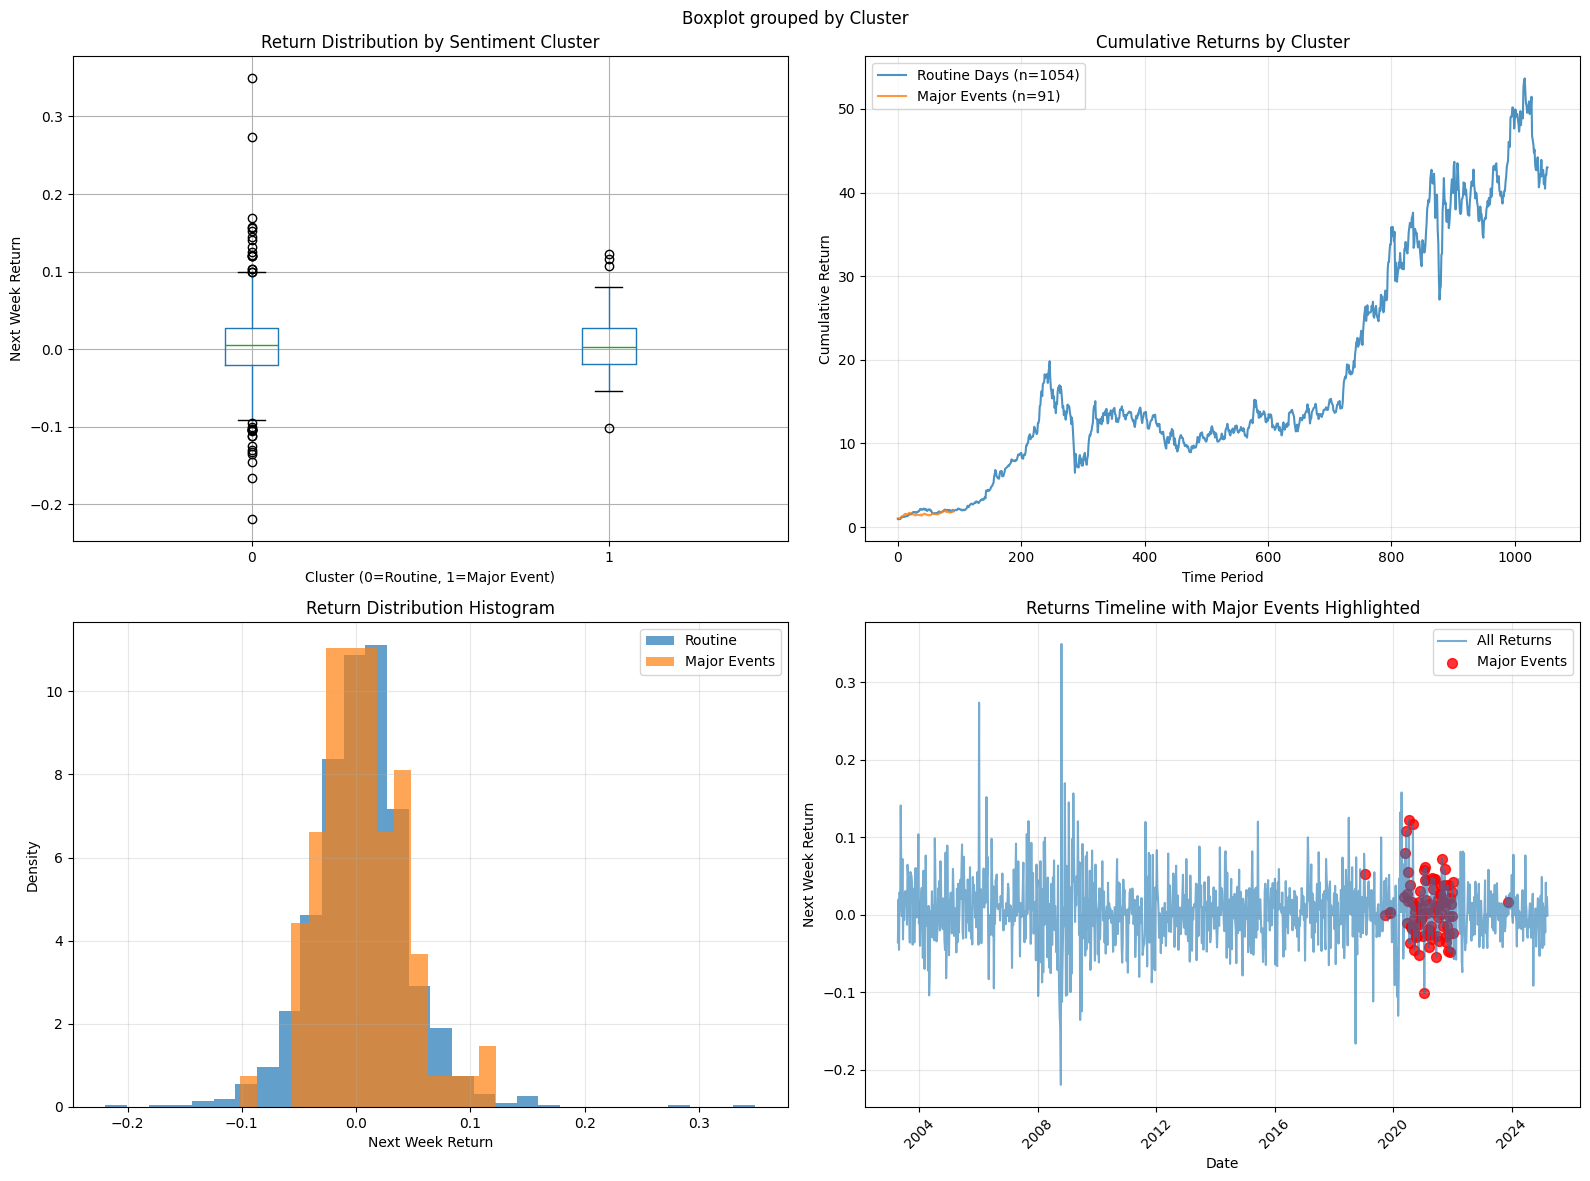


🤖 STEP 6: Building predictive models...
Feature matrix shape: (1145, 769)
Target variable shape: (1145,)
Training set: 916 samples
Test set: 229 samples

🔹 Training Linear Regression...
Linear Regression Results:
  - MSE: 0.021450
  - R²: -22.0839
  - RMSE: 0.1465

🔹 Training Random Forest...
Random Forest Results:
  - MSE: 0.001165
  - R²: -0.2534
  - RMSE: 0.0341

💰 STEP 7: Trading strategy simulation...

📊 TRADING STRATEGY PERFORMANCE:
Model: Random Forest
Total Return: 118.75%
Sharpe Ratio: 0.95
Max Drawdown: -9.23%

Buy-and-Hold Return: 38.03%
🎉 Strategy OUTPERFORMS buy-and-hold!

🎯 FINAL ANALYSIS SUMMARY

📊 DATA SUMMARY:
   - Total trading periods: 1145
   - Major event periods: 91 (7.9%)
   - Date range: 2003-04-14 to 2025-03-17

🎯 KEY INSIGHTS:
   - Major events have 0.87x higher volatility
   - Major event win rate: 57.1%
   - Routine day win rate: 55.9%

🤖 MODEL PERFORMANCE:
   - Best model: Random Forest
   - Best R²: -0.2534
   - Strategy return: 118.75%

🚀 NEXT STEPS:
   

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

print("COMPLETE TRADING ANALYSIS PIPELINE")
print("="*60)

# ==========================================
# STEP 1: LOAD AND PREPARE DATA
# ==========================================
print("\n📂 STEP 1: Loading and preparing data...")

# Load sentiment data with clusters
try:
    sentiment_df = pd.read_csv("sentiment_with_clusters.csv")
    print(f"Sentiment data loaded: {sentiment_df.shape}")
except:
    print("❌ Error: Could not load 'sentiment_with_clusters.csv'")
    print("Make sure you've run the clustering analysis first!")
    exit()

# Load stock data (adjust path as needed)
try:
    reliance = pd.read_csv("reliance.csv")  # Adjust path if needed
    print(f"✅ Stock data loaded: {reliance_1d.shape}")
except:
    print("❌ Error: Could not load stock data")
    print("Please provide the correct path to your stock CSV file")
    exit()

# Fix date formats
print("\n🔧 Fixing date formats...")
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])
reliance['Date'] = pd.to_datetime(reliance['Date'])

print(f"Sentiment date range: {sentiment_df['Date'].min()} to {sentiment_df['Date'].max()}")
print(f"Stock date range: {reliance['Date'].min()} to {reliance['Date'].max()}")

# ==========================================
# STEP 2: CREATE TRADING FEATURES
# ==========================================
print("\n📊 STEP 2: Creating trading features...")

# Calculate stock returns
reliance = reliance.sort_values('Date').reset_index(drop=True)
reliance['Next_Week_Return'] = reliance['Close'].shift(-1) / reliance['Close'] - 1
reliance['Return_Direction'] = (reliance['Next_Week_Return'] > 0).astype(int)

# Create sentiment features
sentiment_df['Is_Major_Event'] = (sentiment_df['Cluster'] == 1).astype(int)
sentiment_df['Market_Significance'] = sentiment_df['Cluster'].map({
    0: 'routine',
    1: 'major_event'
})

print(f"✅ Features created")
print(f"Major events: {sentiment_df['Is_Major_Event'].sum()} ({sentiment_df['Is_Major_Event'].mean()*100:.1f}%)")

# ==========================================
# STEP 3: MERGE DATA
# ==========================================
print("\n🔗 STEP 3: Merging sentiment and stock data...")

# Merge datasets
trading_data = pd.merge(sentiment_df, reliance, on='Date', how='inner')
print(f"✅ Merge successful! Final dataset shape: {trading_data.shape}")

# Remove rows with NaN returns (last row typically)
trading_data = trading_data.dropna(subset=['Next_Week_Return'])
print(f"After removing NaN returns: {trading_data.shape}")

if len(trading_data) == 0:
    print("❌ No overlapping data found! Check your date ranges.")
    exit()

# ==========================================
# STEP 4: EXPLORATORY ANALYSIS
# ==========================================
print("\n📈 STEP 4: Exploratory analysis...")

# Analyze returns by cluster
routine_returns = trading_data[trading_data['Cluster'] == 0]['Next_Week_Return']
major_event_returns = trading_data[trading_data['Cluster'] == 1]['Next_Week_Return']

print(f"\n📊 RETURN ANALYSIS:")
print(f"Routine days (Cluster 0):")
print(f"  - Count: {len(routine_returns)}")
print(f"  - Average return: {routine_returns.mean():.4f} ({routine_returns.mean()*100:.2f}%)")
print(f"  - Volatility (std): {routine_returns.std():.4f}")
print(f"  - Win rate: {(routine_returns > 0).mean()*100:.1f}%")

print(f"\nMajor event days (Cluster 1):")
print(f"  - Count: {len(major_event_returns)}")
print(f"  - Average return: {major_event_returns.mean():.4f} ({major_event_returns.mean()*100:.2f}%)")
print(f"  - Volatility (std): {major_event_returns.std():.4f}")
print(f"  - Win rate: {(major_event_returns > 0).mean()*100:.1f}%")

if len(major_event_returns) > 0 and len(routine_returns) > 0:
    volatility_ratio = major_event_returns.std() / routine_returns.std()
    print(f"\n📊 VOLATILITY RATIO: {volatility_ratio:.2f}x")
    print(f"Major events are {volatility_ratio:.2f}x more volatile than routine days")

# ==========================================
# STEP 5: VISUALIZATION
# ==========================================
print("\n📊 STEP 5: Creating visualizations...")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Return distribution by cluster
trading_data.boxplot(column='Next_Week_Return', by='Cluster', ax=ax1)
ax1.set_title('Return Distribution by Sentiment Cluster')
ax1.set_xlabel('Cluster (0=Routine, 1=Major Event)')
ax1.set_ylabel('Next Week Return')

# 2. Cumulative returns by cluster
routine_cumret = (1 + routine_returns).cumprod()
major_cumret = (1 + major_event_returns).cumprod()

ax2.plot(routine_cumret.values, label=f'Routine Days (n={len(routine_returns)})', alpha=0.8)
if len(major_cumret) > 1:
    ax2.plot(major_cumret.values, label=f'Major Events (n={len(major_cumret)})', alpha=0.8)
ax2.set_title('Cumulative Returns by Cluster')
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Cumulative Return')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Return histogram
ax3.hist(routine_returns, alpha=0.7, bins=30, label='Routine', density=True)
if len(major_event_returns) > 5:
    ax3.hist(major_event_returns, alpha=0.7, bins=15, label='Major Events', density=True)
ax3.set_title('Return Distribution Histogram')
ax3.set_xlabel('Next Week Return')
ax3.set_ylabel('Density')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Time series of returns with events marked
ax4.plot(trading_data['Date'], trading_data['Next_Week_Return'], alpha=0.6, label='All Returns')
major_events = trading_data[trading_data['Cluster'] == 1]
ax4.scatter(major_events['Date'], major_events['Next_Week_Return'], 
           color='red', s=50, alpha=0.8, label='Major Events')
ax4.set_title('Returns Timeline with Major Events Highlighted')
ax4.set_xlabel('Date')
ax4.set_ylabel('Next Week Return')
ax4.legend()
ax4.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# ==========================================
# STEP 6: PREDICTIVE MODELING
# ==========================================
print("\n🤖 STEP 6: Building predictive models...")

# Prepare features (use all sentiment embeddings + cluster info)
feature_cols = [col for col in trading_data.columns if col.isnumeric() or col.startswith('0')]  # Embedding columns
feature_cols.append('Is_Major_Event')

# Get features and target
X = trading_data[feature_cols].fillna(0)
y = trading_data['Next_Week_Return']

print(f"Feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Split data chronologically (important for time series!)
split_point = int(0.8 * len(trading_data))
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Model 1: Linear Regression
print("\n🔹 Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print(f"Linear Regression Results:")
print(f"  - MSE: {lr_mse:.6f}")
print(f"  - R²: {lr_r2:.4f}")
print(f"  - RMSE: {np.sqrt(lr_mse):.4f}")

# Model 2: Random Forest
print("\n🔹 Training Random Forest...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest Results:")
print(f"  - MSE: {rf_mse:.6f}")
print(f"  - R²: {rf_r2:.4f}")
print(f"  - RMSE: {np.sqrt(rf_mse):.4f}")

# Feature importance (Random Forest)
if len(feature_cols) <= 20:  # Only show if not too many features
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🔍 Top 10 Most Important Features:")
    for idx, row in feature_importance.head(10).iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

# ==========================================
# STEP 7: TRADING STRATEGY SIMULATION
# ==========================================
print("\n💰 STEP 7: Trading strategy simulation...")

# Simple strategy: Use model predictions to make trading decisions
def simulate_trading_strategy(predictions, actual_returns, threshold=0.001):
    """
    Simple trading strategy:
    - Buy if predicted return > threshold
    - Sell if predicted return < -threshold
    - Hold otherwise
    """
    signals = np.where(predictions > threshold, 1, 
                      np.where(predictions < -threshold, -1, 0))
    
    # Calculate strategy returns
    strategy_returns = signals * actual_returns
    
    # Calculate metrics
    total_return = np.prod(1 + strategy_returns) - 1
    sharpe_ratio = np.mean(strategy_returns) / np.std(strategy_returns) * np.sqrt(52) if np.std(strategy_returns) > 0 else 0
    max_drawdown = np.min(np.minimum.accumulate(np.cumprod(1 + strategy_returns))) - 1
    
    return {
        'signals': signals,
        'returns': strategy_returns,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }

# Simulate trading with Random Forest predictions
rf_strategy = simulate_trading_strategy(rf_pred, y_test.values)

print(f"\n📊 TRADING STRATEGY PERFORMANCE:")
print(f"Model: Random Forest")
print(f"Total Return: {rf_strategy['total_return']*100:.2f}%")
print(f"Sharpe Ratio: {rf_strategy['sharpe_ratio']:.2f}")
print(f"Max Drawdown: {rf_strategy['max_drawdown']*100:.2f}%")

# Buy-and-hold comparison
buy_hold_return = np.prod(1 + y_test) - 1
print(f"\nBuy-and-Hold Return: {buy_hold_return*100:.2f}%")

if rf_strategy['total_return'] > buy_hold_return:
    print("🎉 Strategy OUTPERFORMS buy-and-hold!")
else:
    print("📉 Strategy underperforms buy-and-hold")

# ==========================================
# STEP 8: FINAL SUMMARY & RECOMMENDATIONS
# ==========================================
print("\n" + "="*60)
print("🎯 FINAL ANALYSIS SUMMARY")
print("="*60)

print(f"\n📊 DATA SUMMARY:")
print(f"   - Total trading periods: {len(trading_data)}")
print(f"   - Major event periods: {sentiment_df['Is_Major_Event'].sum()} ({sentiment_df['Is_Major_Event'].mean()*100:.1f}%)")
print(f"   - Date range: {trading_data['Date'].min().strftime('%Y-%m-%d')} to {trading_data['Date'].max().strftime('%Y-%m-%d')}")

print(f"\n🎯 KEY INSIGHTS:")
if len(major_event_returns) > 0:
    print(f"   - Major events have {volatility_ratio:.2f}x higher volatility")
    print(f"   - Major event win rate: {(major_event_returns > 0).mean()*100:.1f}%")
    print(f"   - Routine day win rate: {(routine_returns > 0).mean()*100:.1f}%")

print(f"\n🤖 MODEL PERFORMANCE:")
print(f"   - Best model: {'Random Forest' if rf_r2 > lr_r2 else 'Linear Regression'}")
print(f"   - Best R²: {max(rf_r2, lr_r2):.4f}")
print(f"   - Strategy return: {rf_strategy['total_return']*100:.2f}%")

print(f"\n🚀 NEXT STEPS:")
print(f"   1. Fine-tune model hyperparameters")
print(f"   2. Implement risk management rules")
print(f"   3. Test on out-of-sample data")
print(f"   4. Consider transaction costs")
print(f"   5. Deploy with paper trading")

print(f"\n💾 Files generated:")
print(f"   - Merged trading data available in memory as 'trading_data'")
print(f"   - Models trained and ready for prediction")

print("\n✅ Analysis complete! Your sentiment-based trading system is ready.")